# Counterfactual Explanations:

In this notebook, we will explore counterfactual explanations, a class of post-hoc explainability methods designed to identify the most influential parts of an image that, if altered, can significantly impact the model’s predictions. These explanations help us understand what features drive the model’s decision-making process by highlighting regions that contribute the most to its classification outcome. Counterfactual reasoning is widely used in explainable AI because it answers "What if?" questions, i.e., what minimal change made to an input could flip the model’s decision? This type of analysis is particularly important in medical imaging and model debugging, as it reveals model vulnerabilities and biases while providing human-interpretable insights.
We use the Captum implementation of Feature Abblation, which can be accessible through [this link](https://captum.ai/tutorials/CIFAR_Captum_Robustness).

## 1. Importing Required Libraries

In [ ]:
import os
from glob import glob

import cv2
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image

from tqdm import tqdm
from torchvision import transforms
from imgaug import augmenters as iaa
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, f1_score, recall_score, precision_score
from torchvision import transforms
from torch import optim
from torch.utils.data import Dataset
import torchvision.models as models

from captum.attr import FeatureAblation
from captum.robust import MinParamPerturbation
import warnings
plt.rcParams['figure.figsize'] = [25, 10]
warnings.filterwarnings("ignore")

## 2. Data Loading and Preprocessing


In this project, we use the "NIH" dataset, which is publicly accessible at [this link](https://www.kaggle.com/datasets/nih-chest-xrays/data). It contains 112120 chest X-rays corresponding to 14 different conditions, e.g., Pneumonia, along with the Normal class. The goal of this project is to develop a deep learning model capable of automatically classifying chest X-ray images into one or more of these conditions. Since each image may have multiple labels, we frame this as a multi-label classification problem consisting of 15 binary classification tasks (14 disease categories + 1 Normal class). This means the model must independently predict the presence or absence of each condition for a given image.

In [ ]:
def read_image(image_path):
    image = cv2.imread(image_path)
    image = image/np.max(image)
    return image

class XrayDataset(Dataset):
    def __init__(self, csv_file, image_path_name):

        self.path_name = image_path_name
        self.csv_file = csv_file
        self.the_chosen, self.all_classes, self.all_classes_dict = self.choose_the_indices()
        self.csv_file["numeric_targets"] = self.csv_file['Finding Labels'].apply(lambda x: self.get_targets(x))
    def __len__(self):

        return len(self.csv_file)
    def choose_the_indices(self):

        max_examples_per_class = 10000 # its the maximum number of examples that would be sampled in the training set for any class
        the_chosen = []
        all_classes = {}
        length = len(self.csv_file)
        for i in tqdm(list(np.random.choice(range(length),length, replace = False))):

            temp = str.split(self.csv_file.iloc[i, :]['Finding Labels'], '|')

            # special case of ultra minority hernia. we will use all the images with 'Hernia' tagged in them.
            if 'Hernia' in temp:
                the_chosen.append(i)
                for t in temp:
                    if t not in all_classes:
                        all_classes[t] = 1
                    else:
                        all_classes[t] += 1
                continue

            # choose if multiple labels
            if len(temp) > 1:
                bool_lis = [False]*len(temp)
                # check if any label crosses the upper limit
                for idx, t in enumerate(temp):
                    if t in all_classes:
                        if all_classes[t]< max_examples_per_class: # 500
                            bool_lis[idx] = True
                    else:
                        bool_lis[idx] = True
                # if all lables under upper limit, append
                if sum(bool_lis) == len(temp):
                    the_chosen.append(i)
                    # maintain count
                    for t in temp:
                        if t not in all_classes:
                            all_classes[t] = 1
                        else:
                            all_classes[t] += 1
            else:        # these are single label images
                for t in temp:
                    if t not in all_classes:
                        all_classes[t] = 1
                    else:
                        if all_classes[t] < max_examples_per_class: # 500
                            all_classes[t] += 1
                            the_chosen.append(i)
        return the_chosen, sorted(list(all_classes)), all_classes

    def get_targets(self,row):
        labels = str.split(row, '|')

        target = torch.zeros(len(self.all_classes))
        for lab in labels:
            lab_idx = self.all_classes.index(lab)
            target[lab_idx] = 1
        return target

    def get_image(self, idx):
        # -- Query the index location of the required file

        image_name = self.csv_file.loc[idx,'Image Index']

        image_path = glob(os.path.join(self.path_name, '**', image_name), recursive=True)[0]
        image = read_image(image_path)
        if len(image.shape) == 2: image = np.expand_dims(image, axis=-1)

        labels = str.split(self.csv_file.loc[idx,'Finding Labels'], '|')

        target = torch.zeros(len(self.all_classes))
        for lab in labels:
            lab_idx = self.all_classes.index(lab)
            target[lab_idx] = 1
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        input_size = 224
        rseed = 42
        seq = iaa.Sequential([iaa.Resize((input_size, input_size))])
        image_transform = transforms.Compose([seq.augment_image, transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        image = image_transform(image)
        return image.float(), target


    def num_sort(self, filename):
        not_num = re.compile("\D")
        return int(not_num.sub("", filename))

    def __getitem__(self, idx):
        image, label = self.get_image(idx)
        return image,label


In [ ]:
image_path = "/ssd003/projects/aieng/public/interp_bootcamp/datasets/NIH"

test_split = os.path.join(image_path,"test_list.txt")
with open(test_split, 'r') as f:
    test_images = f.read().splitlines()
df = pd.read_csv(os.path.join(image_path,"Data_Entry_2017.csv"))
test_df = df[df['Image Index'].isin(test_images)]


In [ ]:
dataset = XrayDataset(df, image_path) # Initializing the dataset

100%|██████████| 112120/112120 [00:14<00:00, 7886.14it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() \
                      else "cpu")

In [ ]:
def load_test_image(data,idx):
    image, label = data[idx]
    image, label = image.to(device) , label.to(device) # transferring the extracted datapoint to the GPU
    image = image.unsqueeze(0)  # Shape: [1, C, H, W] # adding batch dimension (since models expect a batch input)
    return image,label

# Here, we extract a few images from the dataset along with their labels.
image1,label1 = load_test_image(dataset,70)
image2,label2 = load_test_image(dataset,90)
image3,label3 = load_test_image(dataset,100)


## 3. Model

We have fine-tuned a ResNet-18 model, originally pretrained on ImageNet, using the NIH Chest X-ray dataset to classify chest X-ray images into multiple disease categories. For more details on the training process and implementation, you can refer to the train_attention function, which contains the complete training pipeline, including model optimization, and evaluation.

we integrate a self-attention module into the last convolutional block of ResNet-18. This allows the model to focus on salient regions in the images, improving feature selection and enhancing explainability. The self-attention mechanism in this module follows the query-key-value framework, originally introduced in the Transformer architecture:

**Query (Q)**: Represents the features of a given pixel or spatial location.

**Key (K)**: Represents contextual features that help determine the importance of other locations.

**Value (V)**: Contains the actual feature values used for refinement.

The self-attention operation computes the similarity between the query and key, generating attention weights that dictate how much each spatial feature can contribute to the final representation. These weights dynamically adjust the feature maps, helping the model focus on relevant regions in the image.

In [ ]:
# model architechture
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, width * height)
        # calculating attention weights
        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)
        value = self.value(x).view(batch_size, -1, width * height)
        # calculating weighted context
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x # weighted context added to the original input in a residual manner
        return out, attention

class ResNetAttention(nn.Module):
    def __init__(self, original_model,num_classes=15):
        super(ResNetAttention, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        self.attention = SelfAttention(in_dim=512)  # Adjust channels based on ResNet block
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)  # Output channels should match in_channels of attention layer
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x, attention = self.attention(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
# Iniializing hyperparameters
lr = 1e-3
weight_decay = 1e-3

In [ ]:
# Creating a model instance
model = ResNetAttention(models.resnet18(pretrained=True))
model = model.to(device) # transferring the model to the GPU
optimizer = optim.AdamW(model.parameters(), lr=lr,weight_decay=weight_decay)

Here, we load the fine-tuned model checkpoints and use it to generate counterfactual explanations for the extracted image.

In [ ]:
# loading a pretrained model's chechpoints
def load_checkpoint(model, optimizer,file_path):
    checkpoint = torch.load(file_path, map_location=device)

    checkpoint_state_dict = checkpoint['model_state_dict']


    # Create a new state_dict with only the matching keys
    checkpoint_state_dict = {k.replace('module.', ''): v for k, v in checkpoint_state_dict.items()}

    filtered_state_dict = {k: v for k, v in checkpoint_state_dict.items() if k in model.state_dict()}# and "mlp.mlp_layers.dense_1" not in k and "mlp.mlp_layers.dense_0" not in k and "num_norm" not in k}

    model.load_state_dict(filtered_state_dict, strict=False)

    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model

In [ ]:
weight_path = "/ssd003/projects/aieng/public/interp_bootcamp/checkpoints/resnet.pth"
model = load_checkpoint(model, optimizer,weight_path)
model.eval()
# Make predictions
with torch.no_grad():
    logits1 = model(image1)
    logits2 = model(image2)
    logits3 = model(image3)

# Convert output to probabilities
class_probs1 = torch.sigmoid(logits1)
class_probs2 = torch.sigmoid(logits2)
class_probs3 = torch.sigmoid(logits3)

In [ ]:
classes = dataset.all_classes
print(classes)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


## 4. Counterfactual Explanations

To generate counterfactual explanations, we utilize MinParamPerturbation, a perturbation-based explainability technique available on Captum. It operates by systematically ablating different image regions and highlighting the most influential regions that, when removed, significantly affect a model's predictions. It can identify the minimal input perturbation required to change the prediction. This is ufeful for assessing the model's sensitivity to small changes and generating counterfactual explanations and adversarial robustness analysis. [1]

In [ ]:
# extracted from: https://captum.ai/tutorials/CIFAR_Captum_Robustness

# supporting functions for counterfactual generation

def image_show(orig_img, counterfactual,pred):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Normalize image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)

    orig_img = orig_img.squeeze(0).permute(1, 2, 0).cpu() * std + mean
    orig_img = orig_img.clamp(0, 1).detach().cpu().numpy()  # Convert to NumPy for plotting

    # Plot original image
    axes[0].imshow(orig_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")


    transform = transforms.Grayscale(num_output_channels=1)  # Convert to a single channel

    # Apply the transformation
    counterfactual = transform(counterfactual)
    npimg = counterfactual.squeeze(0).squeeze(0).cpu().detach().numpy()
    axes[1].imshow(npimg)
    axes[1].set_title("prediction: %s" % pred)
    axes[1].axis("off")
    plt.show()
    plt.savefig("counter_plot.png")


def get_prediction(model, image, normalize_im=False):
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    image = normalize(image)
    logits = model(image)
    class_probs = torch.sigmoid(logits)
    predictions = (class_probs > 0.5).int()
    disease_predictions = [classes[i] for i in range(len(predictions[0])) if predictions[0][i].item()==1]
    return disease_predictions, torch.sigmoid(logits)

In [ ]:
# extracted from: https://captum.ai/tutorials/CIFAR_Captum_Robustness
def counterfactual_explanation(model, image, label):
    def pixel_dropout(image, dropout_pixels):

        keep_pixels = image[0][0].numel() - int(dropout_pixels)
        vals, _ = torch.kthvalue(pixel_attr.flatten(), keep_pixels)
        return (pixel_attr < vals.item()) * image
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    image.requires_grad = True
    # Get original prediction
    pred, score  = get_prediction(model, image, normalize_im=False)
    preprocess = lambda ims: ims.to(image.device)

    feature_mask = torch.arange(64).reshape(8,8).repeat_interleave(repeats=28, dim=1).repeat_interleave(repeats=28, dim=0).reshape(1,1,224,224).to(image.device)
    ablator = FeatureAblation(model)

    active_labels = torch.nonzero(label.squeeze(), as_tuple=True)[0].to(image.device) # Get the indices of the active labels
    active_label = active_labels[0]

    attr = ablator.attribute(image, target=active_label.to(image.device), feature_mask=feature_mask.to(image.device))
    # Choose single channel, all channels have same attribution scores
    pixel_attr = attr[:,0:1].to(image.device)


    min_pert_attr = MinParamPerturbation(forward_func=model.to(image.device), attack=pixel_dropout, arg_name="dropout_pixels", mode="linear",
                                     arg_min=0, arg_max=1024, arg_step=16,
                                     preproc_fn=preprocess, apply_before_preproc=True)
    pixel_dropout_im, pixels_dropped = min_pert_attr.evaluate(image, target=active_labels.to(image.device), perturbations_per_eval=10)
    # Feature Dropout Image
    new_pred_dropout, score_dropout = get_prediction(model, pixel_dropout_im, normalize_im=False)
    score_dropout_values = ", ".join(map(str, score_dropout.tolist()))
    image_show(image,pixel_dropout_im, new_pred_dropout)

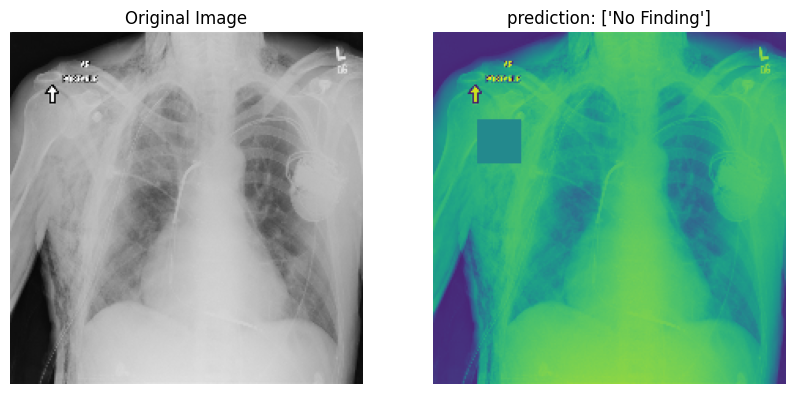

<Figure size 2500x1000 with 0 Axes>

In [ ]:
counterfactual_explanation(model, image1,label1)

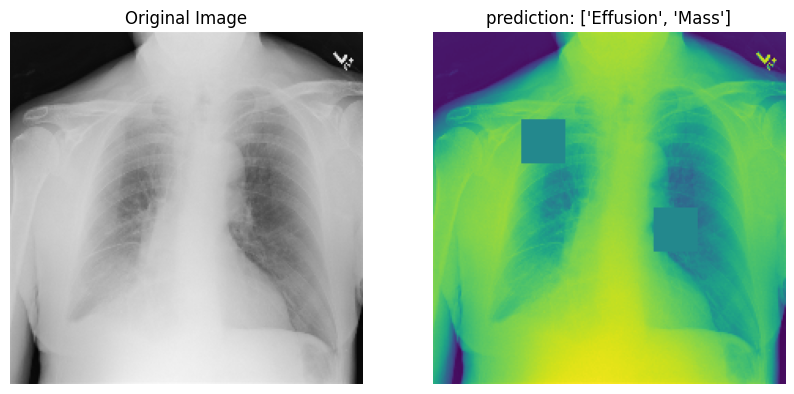

<Figure size 2500x1000 with 0 Axes>

In [ ]:
counterfactual_explanation(model, image2,label2)

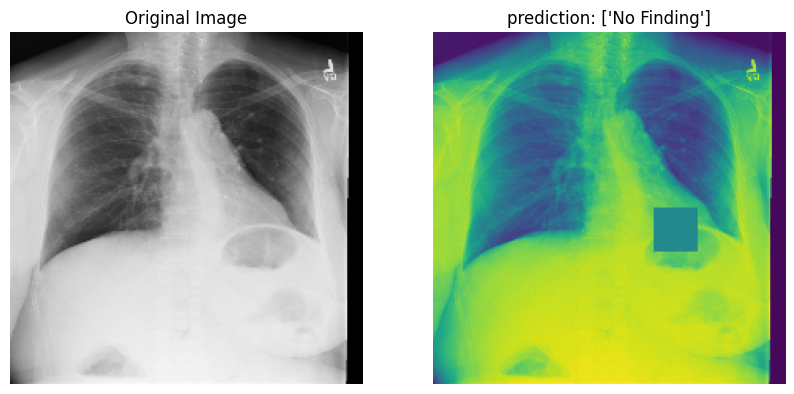

<Figure size 2500x1000 with 0 Axes>

In [ ]:
counterfactual_explanation(model, image3,label3)

The generated explanation highlights regions of the input image that can significantly contribute to the model's prediction. As can be observed, By ablating areas near the border of the lungs, the model's prediction could be change to "Normal". Moreover, for another case, by ablating specific areas within the lung fields, the prediction can be changed to "Effusion" and "Mass". Regarding "Mass", this is expected if these areas correspond to dense elements, as a mass typically represents an abnormal tissue growth. Regarding "Effusion", these areas could correspond to an abnormal accumulation of fluid. Focusing on these elements can indicate that the model is identifying localized abnormalities relevant to the classification. However, determining this requires expert evaluation, such as by a radiologist.

## References
[[1] Captum Robustness with Image Classification](https://captum.ai/tutorials/CIFAR_Captum_Robustness)